This notebook is used to construct an animated GIF illustrating "challenge" solved as part of this PyCon talk.
The challenge is from [Advent of Code 2017 Day 13](http://adventofcode.com/2017/day/13) (Part 2).
See the main notebook for a detailed description of the challenge.

In [1]:
import textwrap
import time
from io import BytesIO, StringIO

In [2]:
# pillow docs: https://pillow.readthedocs.io/en/latest/
import PIL
from PIL import ImageDraw, ImageFont, ImageOps

In [3]:
from IPython.display import clear_output, display, Image

In [4]:
def test_input() -> dict:
    """The demonstration 'firewall'. Each row is a map of column position to height."""
    rows = StringIO(textwrap.dedent(
        """\
        0: 3
        1: 2
        4: 4
        6: 4
        """))
    return {layer: range_ for layer, range_ in (map(int, row.strip().split(': ')) for row in rows)}

In [5]:
SCANNERS = test_input()

In [6]:
# Image size
SPACER = 4
SQUARE_SIZE = 100

cols = 4 + max(SCANNERS.keys()) + 1
IMG_WIDTH = cols * SQUARE_SIZE + (cols - 1) * SPACER

rows = 2 + max(SCANNERS.values())
IMG_HEIGHT = rows * SQUARE_SIZE + (rows - 1) * SPACER

In [7]:
IMG_WIDTH, IMG_HEIGHT

(1140, 620)

In [8]:
# Colors
SCANNER_PRESENT = (229, 80, 57)
SCANNER_ABSENT = (10, 61, 98)

PACKET_FILL = (120, 224, 143)

PATH_FILL = (106, 137, 204)

In [9]:
def py_scanner_layer(scanner_range: int, time_step: int) -> int:
    """Calculates the position of a scanner within its range at a given time step."""
    cycle_midpoint = scanner_range - 1
    full_cycle = cycle_midpoint * 2
    cycle_position = time_step % full_cycle  
    return cycle_position if cycle_position <= cycle_midpoint else full_cycle - cycle_position

In [10]:
def draw_scanner(draw: ImageDraw.Draw, col: int, range_: int, t: int):
    """Draw one 'scanner' within the firewall."""
    col_left = (SQUARE_SIZE + SPACER) * col
    for row in range(1, range_ + 1):
        row_top = (SQUARE_SIZE + SPACER) * row
        scanner_layer = py_scanner_layer(range_, t)
        if scanner_layer + 1 == row:
            color = SCANNER_PRESENT
        else:
            color = SCANNER_ABSENT
        draw.rectangle([(col_left, row_top), (col_left + SQUARE_SIZE, row_top + SQUARE_SIZE)], fill=color)

In [11]:
def draw_scanners(draw: ImageDraw.Draw, scanners: dict, t: int):
    """Draw all of the 'scanners' in the firewall."""
    for col, range_ in scanners.items():
        draw_scanner(draw, col + 2, range_, t)

In [12]:
def draw_packet(draw: ImageDraw.Draw, t: int):
    """Draw the 'packet' at a given time step."""
    packet_offset = SQUARE_SIZE // 5
    col_left = SQUARE_SIZE + SPACER
    row_top = SQUARE_SIZE + SPACER
    packet_pos = 1
    if t >= 10:
        packet_pos = t - 9 + 1
        col_left = (SQUARE_SIZE + SPACER) * packet_pos
    draw.ellipse(
        [(col_left + packet_offset, row_top + packet_offset), 
         (col_left + SQUARE_SIZE - packet_offset, row_top + SQUARE_SIZE - packet_offset)],
        fill=PACKET_FILL)
    return packet_pos

In [13]:
def draw_path(draw: ImageDraw.Draw, packet_pos: int):
    """Draws a circle for each square in the path of our 'packet'."""
    path_offset = SQUARE_SIZE // 3
    row_top = SQUARE_SIZE + SPACER + path_offset
    row_bottom = SQUARE_SIZE + SPACER + SQUARE_SIZE - path_offset
    for i in range(1, max(SCANNERS.keys()) + 4):
        if i == packet_pos:
            # don't draw a path circle at the current position of the packet
            continue
        col_left = (SQUARE_SIZE + SPACER) * i + path_offset
        col_right = (SQUARE_SIZE + SPACER) * i + SQUARE_SIZE - path_offset
        draw.ellipse([(col_left, row_top), (col_right, row_bottom)], fill=PATH_FILL)

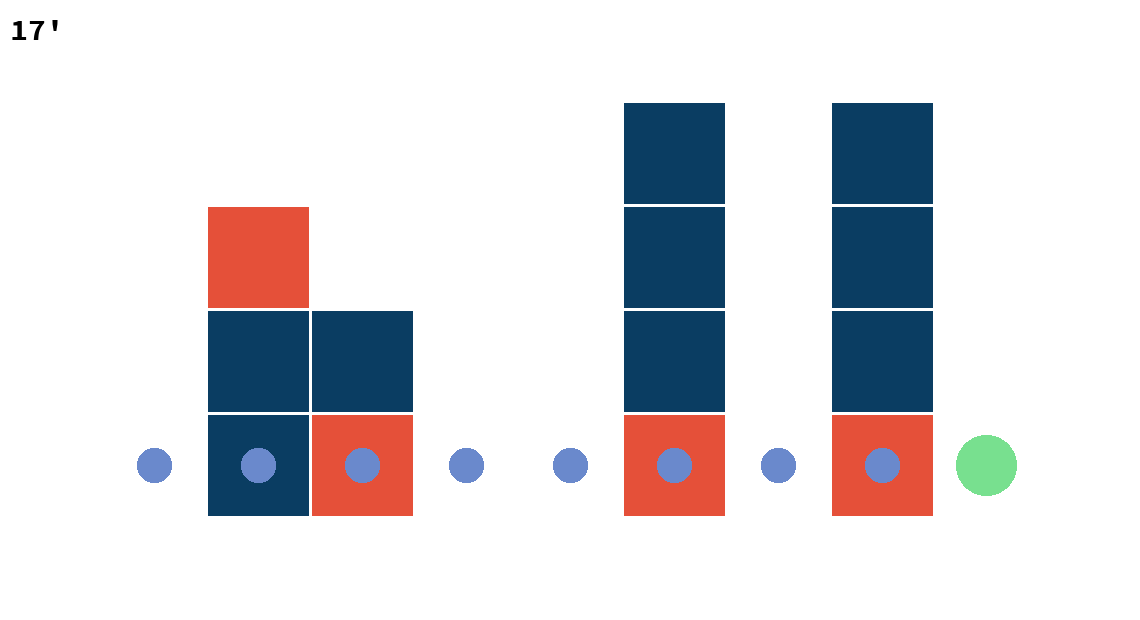

In [15]:
backup = PIL.Image.new('RGB', (IMG_WIDTH, IMG_HEIGHT), 'white')
# Source Code Pro: https://github.com/adobe-fonts/source-code-pro
# Or select a truetype font available on your system
font = ImageFont.truetype('SourceCodePro-Bold.ttf', size=30)

for t in range(0, 18 * 2):
    frame = backup.copy()
    draw = ImageDraw.Draw(frame)
    
    # Each time step is divided in two: in the first half the packet moves
    # and in the second half the scanners move.
    # This is implemented by moving the packet on even time steps
    # and scanners on the odd time steps.
    if t % 2 == 0:
        # packet moves
        draw_scanners(draw, SCANNERS, t // 2)
        append = ''
    else:
        # scanners move (indicated with a ' marker on time step numbers)
        draw_scanners(draw, SCANNERS, t // 2 + 1)
        append = '\''
    
    packet_pos = draw_packet(draw, t // 2)
    draw_path(draw, packet_pos)
    
    # flip to put the path on the bottom
    frame = ImageOps.flip(frame)
    draw = ImageDraw.Draw(frame)
    draw.text((10, 10), str(t // 2) + append, fill='black', font=font)
    
    # Display the image in the notebook to preview the animation
    clear_output(wait=True)
    display(frame)
    time.sleep(1)
    
    frame.save(f'./images/frame{t // 2:02}{"_" if append else ""}.gif')

Use [ImageMagick](https://www.imagemagick.org/script/index.php) to convert all of the frames to an animated gif with a spacing of 1 second.
(Run as a shell command.)

In [2]:
!convert -delay 50 images/frame*.gif images/scanners.gif